In [6]:
import openmc
import numpy as np

In [7]:
# UO2 fuel kernel
uo2 = openmc.Material(name='UO2', temperature=900)
uo2.add_element('U', 1.0, enrichment=0.71)  
uo2.add_element('O', 2.0)
uo2.set_density('g/cm3', 10.5)

# SiC coating
sic = openmc.Material(name='SiC', temperature=900)
sic.add_element('Si', 1.0)
sic.add_element('C', 1.0)
sic.set_density('g/cm3', 3.2)

# Lead-Lithium (Pb83at%-Li17at%)
pbli = openmc.Material(name='PbLi', temperature=900)
pbli.add_element('Pb', 0.83)
pbli.add_element('Li', 0.1, enrichment_target='Li6', enrichment_type='wo', enrichment=90.0)
pbli.set_density('g/cm3', 9.5) 

materials = openmc.Materials([uo2, sic, pbli])
# materials.cross_sections = '/mnt/c/OpenMC/data/endfb-viii.0-hdf5/cross_sections.xml'
# materials.export_to_xml()

In [8]:
# UO2 kernel sphere (radius = 0.04 cm)
kernel_outer = openmc.Sphere(r=0.04)

# SiC coating outer surface (radius = 0.04 + 0.01 = 0.05 cm)
sic_outer = openmc.Sphere(r=0.05)

# Reflective cube boundaries 
# cube_length = 0.374  # cm
cube_length = 0.102  # cm
cube_half   = cube_length / 2
# cube_length = 0.374  # cm for BISO particle to be  1% vol # = ((4/3(pi)(0.05)^3)/0.01)^(1/3) = 0.37411019268
# cube_length = 0.102  # cm for BISO particle to be 50% vol # = ((4/3(pi)(0.05)^3)/0.5)^(1/3) = 0.10154912975

x_min = openmc.XPlane(-cube_half, boundary_type='vacuum')
x_max = openmc.XPlane( cube_half, boundary_type='vacuum')
y_min = openmc.YPlane(-cube_half, boundary_type='vacuum')
y_max = openmc.YPlane( cube_half, boundary_type='vacuum')
z_min = openmc.ZPlane(-cube_half, boundary_type='vacuum')
z_max = openmc.ZPlane( cube_half, boundary_type='vacuum')

# UO2 kernel
cell_kernel = openmc.Cell(name='UO2_kernel')
cell_kernel.fill = uo2
cell_kernel.region = -kernel_outer

# SiC coating
cell_sic = openmc.Cell(name='SiC_coating')
cell_sic.fill = sic
cell_sic.region = +kernel_outer & -sic_outer

# Lead-Lithium matrix
cell_pbli = openmc.Cell(name='PbLi_matrix')
cell_pbli.fill = pbli
cell_pbli.region = +sic_outer & +x_min & -x_max & +y_min & -y_max & +z_min & -z_max

# Create universe and geometry
root_universe = openmc.Universe(cells=[cell_kernel, cell_sic, cell_pbli])
geometry = openmc.Geometry(root_universe)
# geometry.export_to_xml()

<Axes: xlabel='y [cm]', ylabel='z [cm]'>

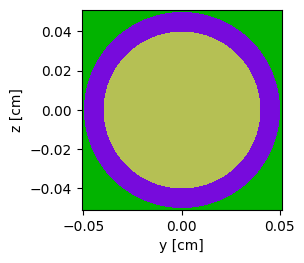

In [9]:
img = geometry.plot(
    basis='yz',                           # slice plane
    width=(cube_length, cube_length),     # cm window
    pixels=(200, 200),
    color_by='material')
display(img)

In [10]:
settings = openmc.Settings()

"""Source: 14 MeV from -x face toward +x"""
eps = 1e-8
source = openmc.IndependentSource()
source.space = openmc.stats.Box((-cube_half,-cube_half,-cube_half),
                                ( cube_half, cube_half, cube_half),
                                 only_fissionable=False) # openmc.stats.Point((-cube_half+eps,-cube_half+eps,-cube_half+eps))
source.particle = 'neutron'
source.energy   = openmc.stats.Discrete([14.0e6], [1.0])  # 14 MeV
# source.angle    = openmc.stats.Monodirectional((0, 0, 1))

"""Settings"""
settings = openmc.Settings()
settings.run_mode  = "fixed source"
settings.batches   = 10
settings.particles = int(1e4)
settings.sources   = [source]
settings.write_initial_source = True

In [11]:
"""Tallies: region split + 1D centerline mesh"""
tallies = openmc.Tallies()
# 1D mesh along x, narrow pencil in y, z around the center
# r = 0.00125
# r_grid = [0, 0.00125]
# z_grid = np.linspace(-cube_half, cube_half, num=501, endpoint=True)
# mesh = openmc.CylindricalMesh(r_grid, z_grid)

yz = 0.125
mesh = openmc.RegularMesh()
mesh.dimension = (100, 100, 100) # 200 = number of bins in x axis
mesh.lower_left  = (-cube_half, -cube_half, -cube_half)
mesh.upper_right = ( cube_half,  cube_half,  cube_half)

mesh_filter = openmc.MeshFilter(mesh)

# flux
t_flux_1d = openmc.Tally(name="flux_mesh_1d_x")
t_flux_1d.filters = [mesh_filter]
t_flux_1d.scores = ["flux"]
tallies.append(t_flux_1d)

# (n,γ) on 1D mesh (all materials)
t_ng_1d = openmc.Tally(name="ng_mesh_1d_x")
t_ng_1d.filters = [mesh_filter]
t_ng_1d.scores = ["(n,gamma)"]
tallies.append(t_ng_1d)

# Total reaction rate on 1D mesh (all materials)
# 'total' = Σ_total * flux (absorption + scattering etc.)
t_total_1d = openmc.Tally(name="total_mesh_1d_x")
t_total_1d.filters = [mesh_filter]
t_total_1d.scores = ["total"]
tallies.append(t_total_1d)

In [12]:
model = openmc.Model(geometry, materials, settings, tallies)
model.export_to_xml()
model.run() 

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/mnt/c/MCNP/emma-openmc/Jupyter2/statepoint.10.h5')

[9.35240253e-09 9.30660156e-09 3.91729581e-08 ... 1.14630625e-08
 1.24188294e-08 3.19478265e-09]


ValueError: x and y must have same first dimension, but have shapes (100,) and (1000000,)

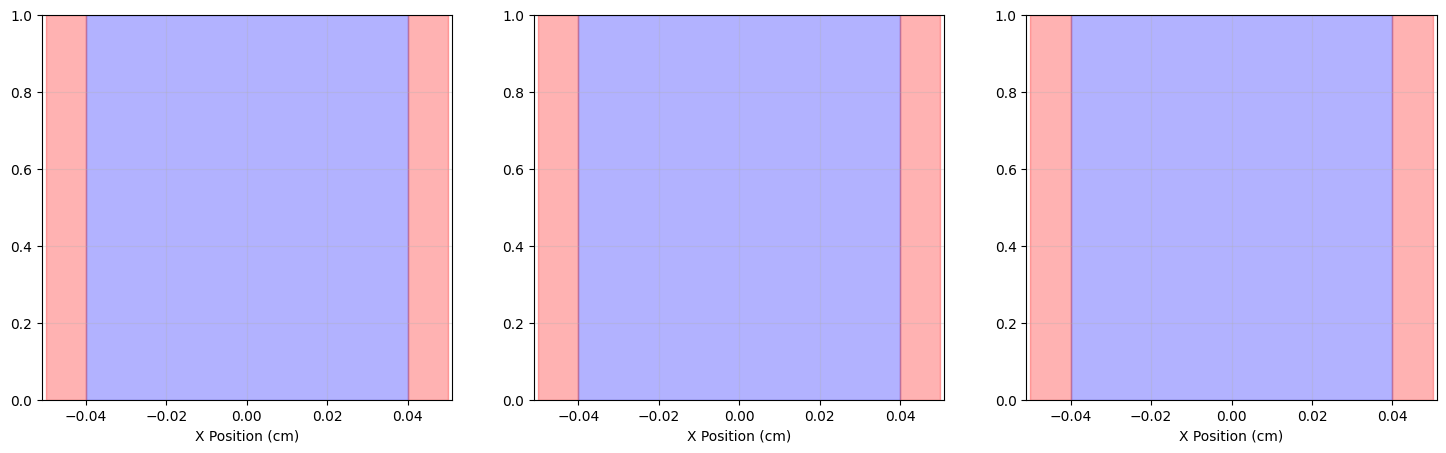

In [15]:
import matplotlib.pyplot as plt

with openmc.StatePoint('statepoint.10.h5') as sp:

    # Get 1D flux tallies
    tally_1d = sp.get_tally(name='flux_mesh_1d_x')
    ng_1d    = sp.get_tally(name='ng_mesh_1d_x')
    total_1d = sp.get_tally(name='total_mesh_1d_x')

    mesh  = tally_1d.find_filter(openmc.MeshFilter).mesh
    flux_mean,   flux_std = tally_1d.mean.ravel(), tally_1d.std_dev.ravel()
    ng_mean,       ng_std =    ng_1d.mean.ravel(),    ng_1d.std_dev.ravel()
    total_mean, total_std = total_1d.mean.ravel(), total_1d.std_dev.ravel()

    # Mesh coordinates
    x_min, x_max = mesh.lower_left[0], mesh.upper_right[0]
    nx = 100
    x_positions = np.linspace(x_min, x_max, nx + 1)
    x_centers = (x_positions[:-1] + x_positions[1:]) / 2

    # --- Multi-panel plot setup ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

    # Define common shaded regions for materials
    for ax in axes:
        ax.axvspan(-0.04, 0.04, alpha=0.3, color='blue', label='UO$_2$ kernel')
        ax.axvspan(0.04, 0.05, alpha=0.3, color='red', label='SiC shell')
        ax.axvspan(-0.05, -0.04, alpha=0.3, color='red')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(x_min, x_max)
        ax.set_xlabel('X Position (cm)')

    # --- Plot each quantity separately ---
    axes[0].plot(x_centers, flux_mean, '-', lw=1.2, color='black')
    axes[0].set_title('Neutron Flux')
    axes[0].set_ylabel('Flux (n/cm$^2$/source)')

    axes[1].plot(x_centers, ng_mean, '-', lw=1.2, color='green')
    axes[1].set_title('(n,γ) Reaction Rate')

    axes[2].plot(x_centers, total_mean, '-', lw=1.2, color='orange')
    axes[2].set_title('Total Reaction Rate')

    # Common legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Optionally save
    # fig.savefig('flux_profiles_side_by_side.png', dpi=150, bbox_inches='tight')